In [2]:
import pandas as pd
import ssl
import time
import datetime

def get_df(addr):
    ssl._create_default_https_context = ssl._create_unverified_context
    transactions_url = 'https://blockchain.info/rawaddr/' + addr
    df = pd.read_json(transactions_url)
    time.sleep(10)
    return df

def find_transactions(df): 
    transactions = df['txs']
    return transactions 

def find_inputaddr(df):
    transactions = find_transactions(df) 
    inputaddrs = []
    for transaction in transactions:
        inputaddrs.append(transaction['inputs'][0]['prev_out']['addr'])
    return inputaddrs

def find_outputaddr(df):
    transactions = find_transactions(df) 
    outputaddr = []
    for transaction in transactions:
        outputaddr.append(transaction['out'][0]['addr'])
    return outputaddr

def find_amounts(df):
    transactions = find_transactions(df)
    amounts = []
    for transaction in transactions:
        amounts.append(transaction['result'])
    return amounts

def find_time(df):
    transactions = find_transactions(df)
    times = []
    for transaction in transactions:
        time = transaction['time']
        dt = datetime.datetime.fromtimestamp(time)
        dt_format = dt.strftime("%Y-%m-%d %H:%M:%S")
        times.append(dt_format)
    return times

def get_hops(df,n_hops,addr):
    inputaddrs = []
    outputaddrs = []
    amounts = []
    times = []
    
    inputaddrs.append(addr)
    outputaddrs.append(find_outputaddr(df)[0])
    amounts.append(find_amounts(df)[0])
    times.append(find_time(df)[0])
    
    new_address = find_outputaddr(df)[0]
    df = get_df(new_address)
    
    for hop in range(n_hops):
        inputaddrs.append(find_inputaddr(df)[0])
        ## retrieves first address
        outputaddrs.append(find_outputaddr(df)[0]) # adds address to trns
        
        amounts.append(find_amounts(df)[0])
        
        ## find time
        times.append(find_time(df)[0])
        
        new_address = find_outputaddr(df)[0] # moves onto the next address
        df = get_df(new_address) # collect new set of df
        
        print(f'Completed {hop+1} hops...')
        
    return inputaddrs,outputaddrs,amounts,times

def get_dataframe(inputaddress,outputaddress,amounts,times):
    data = {'input_address': inputaddress,
            'transactions': outputaddress,
            'amount': amounts,
            'time_of_transaction':times
           }
    dataframe = pd.DataFrame(data)
    return dataframe

def get_n_hops(n_hops,addr):
    df = get_df(addr)
    inputaddress,outputaddress,amounts,times = get_hops(df,n_hops,addr)
    dataframe = get_dataframe(inputaddress,outputaddress,amounts,times)
    return dataframe

In [1]:
'''
Defining Matplotlib function for plotting
'''
import textwrap
from matplotlib import pyplot as plt
from matplotlib.patches import FancyArrowPatch

plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200

def plot_n_hops(dataframe,n_hops,addr): ## plot number of hops
    fontsz = 6
    sending_rectangle = plt.Rectangle((3, 3), width=4, height=2, 
                                      facecolor = 'gainsboro', 
                                      edgecolor = 'black')
    plt.annotate(textwrap.fill(addr,width = 17), ((0)*7+5, 4), 
                 horizontalalignment = 'center', 
                 verticalalignment = 'center', 
                 fontsize = fontsz)
    ax = plt.gca()  
    for n in range(n_hops):
        rect = plt.Rectangle((7*(n+1)+3,3), width = 4, height = 2, 
                             facecolor = 'gainsboro', 
                             edgecolor = 'black')
        arrow = FancyArrowPatch((7*(n+1), 4), (7*(n)+10,4), 
                                edgecolor = 'lightgray', 
                                arrowstyle = 'simple',
                                mutation_scale = 10,
                                connectionstyle = 'angle3')
        plt.annotate(str(dataframe['amount'][n]/(10**8)) + ' BTC', (7.1+7*(n), 3.6), 
                     fontsize = fontsz)
        plt.annotate(textwrap.fill(dataframe['transactions'][n],width = 17), (12+7*(n), 4), 
                     horizontalalignment = 'center', 
                     verticalalignment = 'center', 
                     fontsize = fontsz)
        
        ax.add_patch(rect)
        ax.add_patch(arrow)      
    ax.add_patch(sending_rectangle)
    
    plt.axis("scaled")
    plt.axis("off")
    plt.show()

Completed 1 hops...


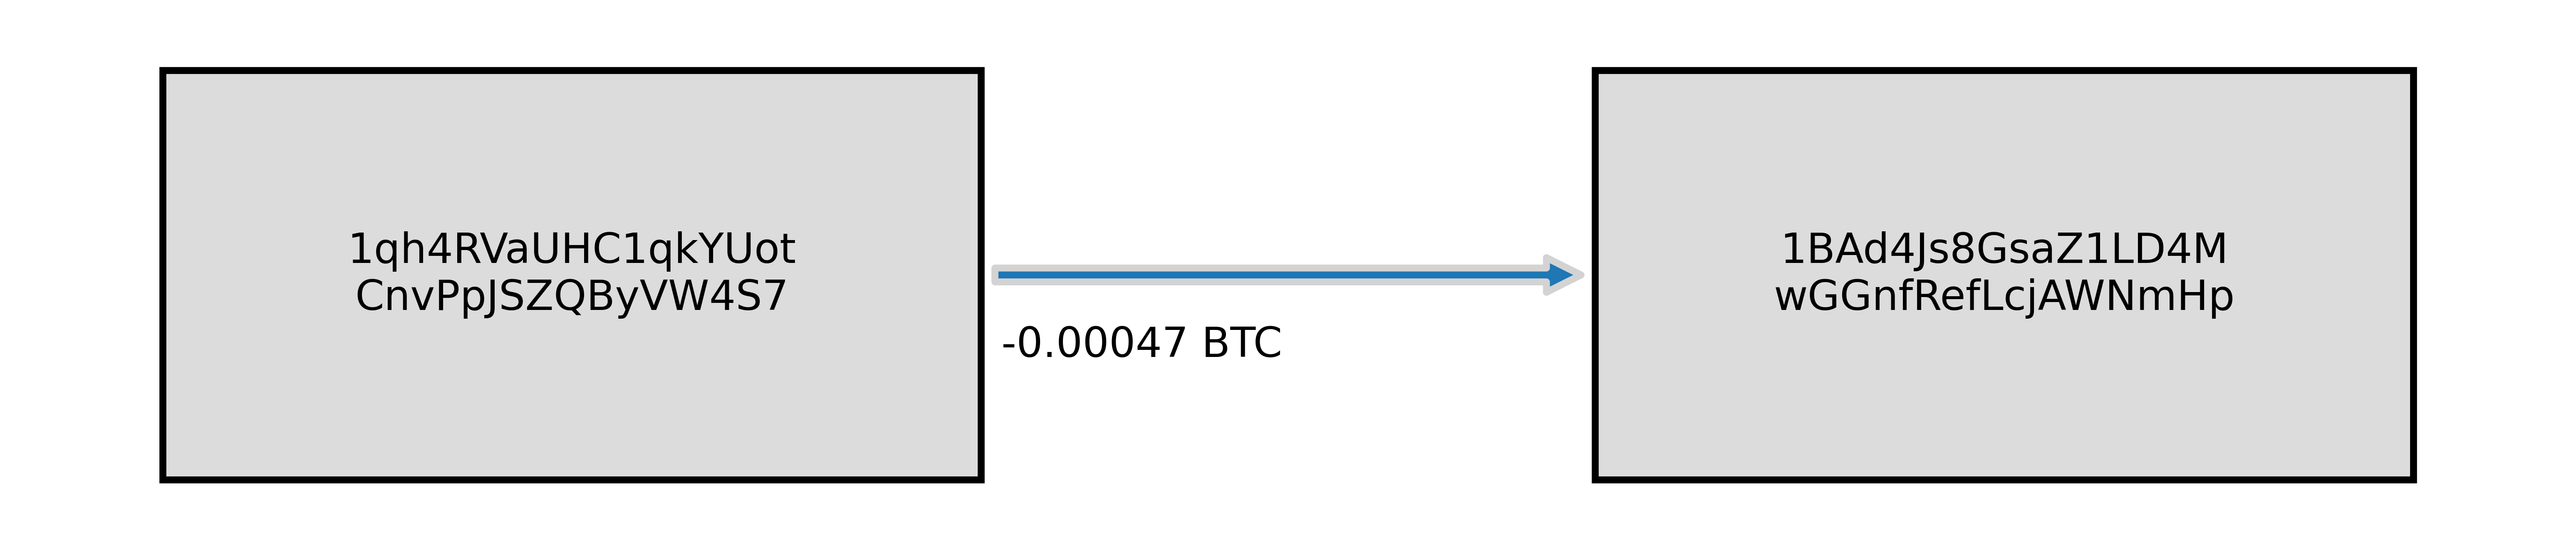

In [2]:
## Test case 1: Bitcoin address with 1 hop and amount
addr = '1qh4RVaUHC1qkYUotCnvPpJSZQByVW4S7'
numofhops = 1

dataframe = get_n_hops(numofhops,addr)
plot_n_hops(dataframe,numofhops,addr)

Completed 1 hops...
Completed 2 hops...


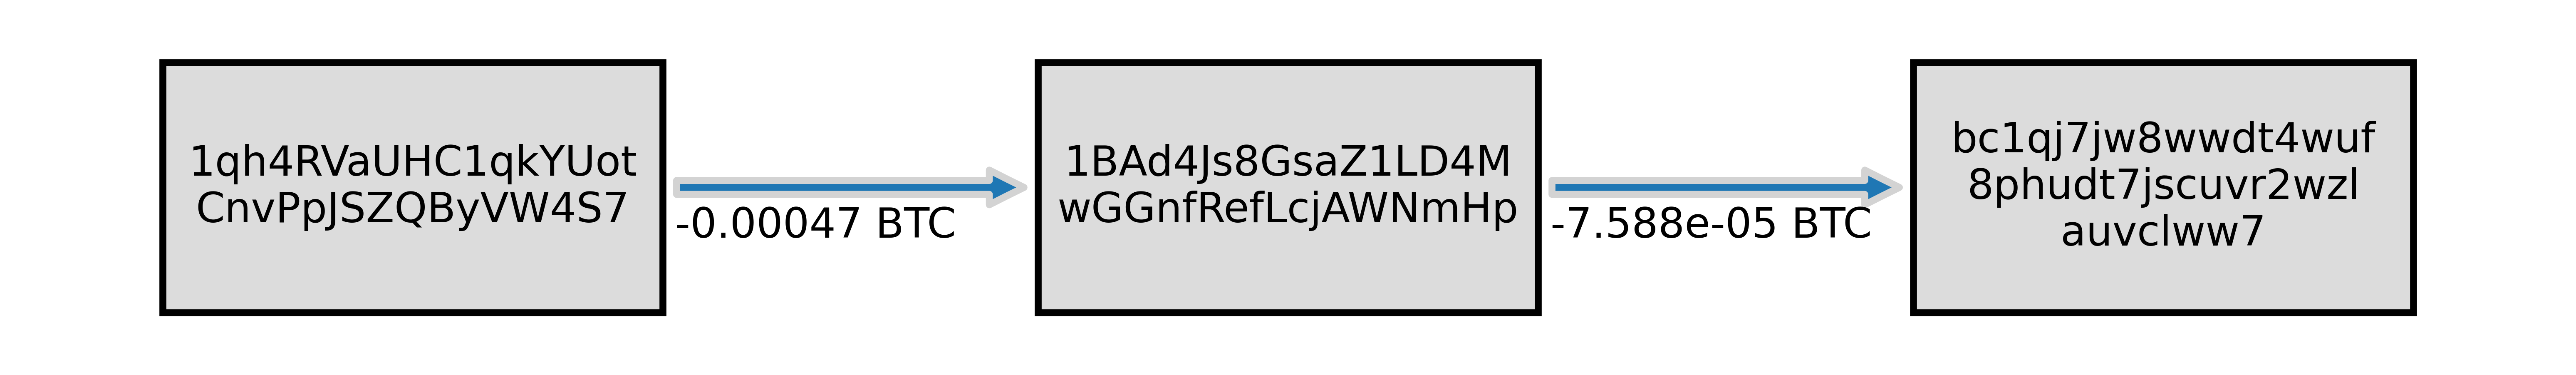

In [3]:
## Test case 2: Bitcoin address with 2 hops and amounts
addr = '1qh4RVaUHC1qkYUotCnvPpJSZQByVW4S7'
numofhops = 2

dataframe = get_n_hops(numofhops,addr)
plot_n_hops(dataframe,numofhops,addr)

In [6]:
'''
The following section is for plotting with legends
'''

import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.text as mpl_text

## create an object
class TextObject(object):
    def __init__(self, text, color):
        self.my_text = text
        self.my_color = color
        
        
## define the methods
class TextObjectHandler(object):
    def legend_artist(self, legend, orig_handle, fontsize, handlebox):
        x0, y0 = handlebox.xdescent, handlebox.ydescent
        width, height = handlebox.width, handlebox.height
        
        patch = mpl_text.Text(x=0, y=0, text=orig_handle.my_text)
        handlebox.add_artist(patch)
        return patch

def get_fontsize(number):
    fontsize = 5 - (number -1)*0.5
    return max(1, fontsize)

def create_legend(dataframe,n_txns,addr):
    handles = []
    labels = []
    obj = TextObject(str(), 'black')
    handles.append(obj)
    labels.append(f"{1}:  {addr}")
    for i in range(1, n_txns+1):
        obj = TextObject(str(), 'black')
        handles.append(obj)
        labels.append(f"{i+1}:  {dataframe.loc[i-1, 'transactions']+'_'+dataframe.loc[i-1, 'time_of_transaction']}")
        
    plt.legend(handles, labels, bbox_to_anchor=(1.05, 1), loc='upper left', 
            handler_map={obj:TextObjectHandler() for obj in handles},
            fontsize=get_fontsize(n_txns))

## Testing our the legend option for address display - Text handlers
plt.rcParams['figure.dpi'] = 1200
plt.rcParams['savefig.dpi'] = 1200

def plot_n_hops_legends(dataframe,n_txns,addr): # plot number of transactions
    input_circle = plt.Circle((5, 4), radius=1, facecolor="gainsboro", edgecolor="black")
    plt.text(5,4,1,horizontalalignment='center',verticalalignment='center',fontsize=get_fontsize(n_txns))
    ax = plt.gca()  
    for n in range(n_txns):
        circle = plt.Circle((5+7*(n+1), 4), radius = 1, facecolor="gainsboro", edgecolor="black")
        arrow = FancyArrowPatch((6+7*(n), 4), (7*(n)+11,4), edgecolor="lightgray", arrowstyle="simple",mutation_scale=10,connectionstyle="angle3")
        plt.annotate(str(dataframe['amount'][n]/(10**8)) + ' BTC', (7.1+7*(n), 3.6), fontsize=get_fontsize(n_txns))
        plt.text(5+7*(n+1),4,(n+2),horizontalalignment='center',verticalalignment='center',fontsize=get_fontsize(n_txns))
        
        ax.add_patch(circle)
        ax.add_patch(arrow)      
        
    create_legend(dataframe,n_txns,addr)
    ax.add_patch(input_circle)
    plt.axis("scaled")
    plt.axis("off")
    plt.show()

Completed 1 hops...
Completed 2 hops...
Completed 3 hops...
Completed 4 hops...


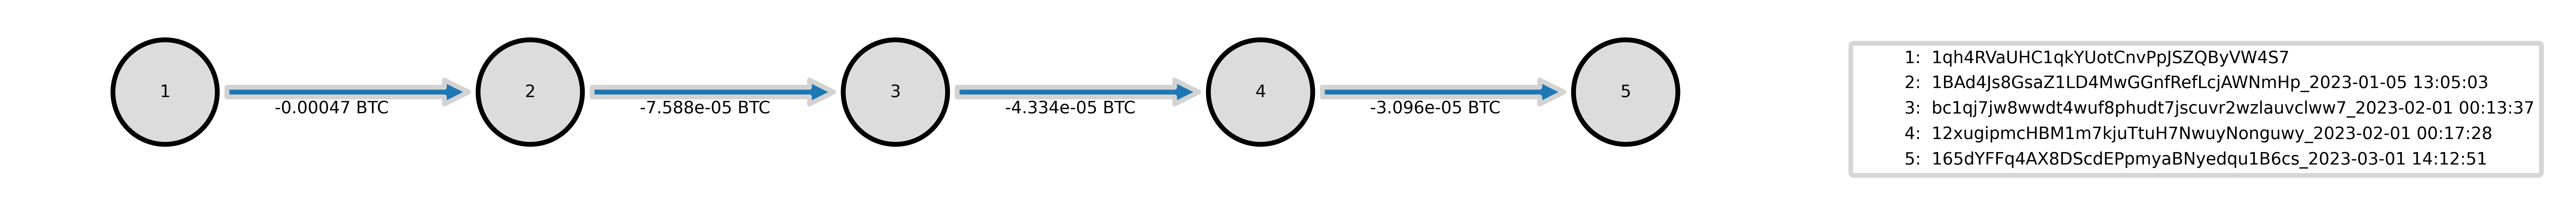

In [7]:
## Test case 1: Bitcoin address with 4 hops and amounts with legends
addr = '1qh4RVaUHC1qkYUotCnvPpJSZQByVW4S7'
numofhops = 4

dataframe = get_n_hops(numofhops,addr)
plot_n_hops_legends(dataframe,numofhops,addr)

Completed 1 hops...
Completed 2 hops...
Completed 3 hops...
Completed 4 hops...
Completed 5 hops...
Completed 6 hops...
Completed 7 hops...
Completed 8 hops...


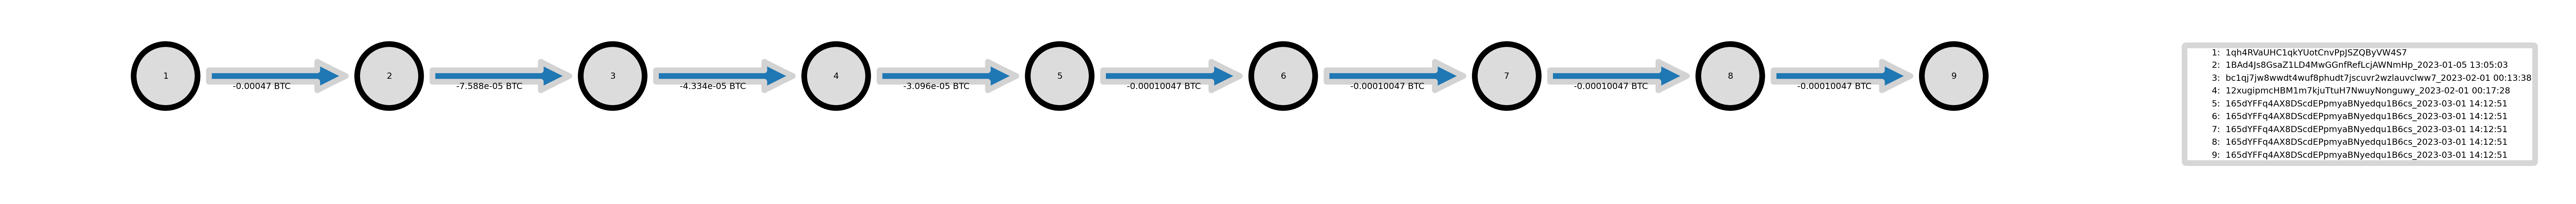

In [8]:
## Test case 2: Bitcoin address with 8 hops and amounts with legends
addr = '1qh4RVaUHC1qkYUotCnvPpJSZQByVW4S7'
numofhops = 8

dataframe = get_n_hops(numofhops,addr)
plot_n_hops_legends(dataframe,numofhops,addr)

In [9]:
## Test case 3: Bitcoin address with slider implementation
addr = '1qh4RVaUHC1qkYUotCnvPpJSZQByVW4S7'
numofhops = 8

dataframe = get_n_hops(numofhops,addr)
interact(plot_n_hops_legends,dataframe=fixed(dataframe),n_txns=(1,numoftransactions,1),addr = fixed(addr))

Completed 1 hops...
Completed 2 hops...
Completed 3 hops...
Completed 4 hops...
Completed 5 hops...
Completed 6 hops...
Completed 7 hops...
Completed 8 hops...


NameError: name 'interact' is not defined